In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from keras import backend as K
from tensorflow.keras import initializers
import PIL
from PIL import ImageOps
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from imageio import imread
from keras.layers import concatenate
from keras.utils import plot_model
%matplotlib inline

# workstation used
ans = input('self or lab: ')
if ans == 'self':
    idi = '/home/neo11/Documents'
    print('using neo11')
else:
    idi = '/home/melcher/Documents/Nihal'
    print('using melcher')

2022-07-27 20:59:16.457003: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


self or lab: self
using neo11


In [24]:
# paramters
# stride 1
s1 = 1
# stride 2
s2 = 2

# input image size for 1 color(a*b)
a =128
b = 128

# type of image
g = 1 # grayscale
rgb =3 # RGB image 

# no. of filters
f1 = 16
f2 = 32

# kernel size
n = 5
m =3
n1 =4

#padding
p =2

# epochs
epochs = 100

# image size
image_size = (a,b)

# batch size
batch_size = 16

# learning rate
lr = 0.001

dataset_path = idi + '/ML in microfluids/main dataset/svd_compiled/train' #'/content/drive/MyDrive/ML in microfluids/train'
testing_path = idi + '/ML in microfluids/main dataset/svd_compiled/test' #'/content/drive/MyDrive/ML in microfluids/cvd'

# data generator
train_datagen =ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_batches = train_datagen.flow_from_directory(
    dataset_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    subset = 'training',
    color_mode = 'grayscale',
    shuffle = True
)

validation_batches = train_datagen.flow_from_directory(
    dataset_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    subset = 'validation',
    color_mode = 'grayscale',
    shuffle = True
)

test_batches = test_datagen.flow_from_directory(
    testing_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    color_mode = 'grayscale'
)

original or 2? or random: random
Found 496 images belonging to 2 classes.
Found 123 images belonging to 2 classes.
Found 471 images belonging to 2 classes.


In [25]:
def n_gray(img):
    ii = np.array(img)
    r, g, b = ii[:,:,0], ii[:,:,1], ii[:,:,2]
    rf , gf, bf = 0.5, 2, 1.5
    a = (rf*r +gf*g + bf*b)/4
    return a

In [26]:
# printing n images from the batches
n = int(input('no. of images in plot: '))

def plot(img_arr):
  fig, axes = plt.subplots(1,n)
  axes = axes.flatten()
  for img, ax in zip(img_arr, axes):
    ax.imshow(img, cmap ='gray')
    ax.axis('off')
  plt.tight_layout()
  plt.show()

no. of images in plot: 4


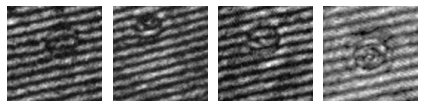

[0. 0. 0. 1.]


In [27]:
# for training batches
imgs, labels = train_batches[1]
plot(imgs)
print(labels[:n])

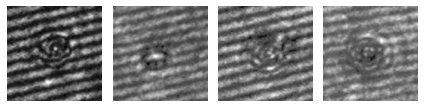

[1. 0. 1. 1.]


In [28]:
# for validation batches
imgs, labels = validation_batches[2]
plot(imgs)
print(labels[:n])

In [29]:
print(train_batches.class_indices)
print(test_batches.class_indices)

{'Cell': 0, 'comp': 1}
{'cell': 0, 'comp': 1}


In [20]:
def block1(input_img):
    # taking input and applying 64 8x8 kernels, with stride = 2, relu acvtivation for c1
    # Conv2D : no. kernels, size, stride, activation, padding (valid = no padding, same = paddding such that size of output remains same as input)
    c1 = keras.layers.Conv2D(64, 8, 2, activation = 'relu', padding = 'valid')(input_img)
    # use of size 1x1 kernels to extensively learn variations between layers rather than convolution of pixels
    c2 = keras.layers.Conv2D(64, 1, activation = 'relu', padding = 'valid')(c1)
    c3 = keras.layers.Conv2D(96, 6, activation = 'relu', padding = 'valid')(c2)
    # max pool to reduce size and get most bright pixel in the neighbourhood
    c4 = keras.layers.MaxPooling2D(pool_size = (2,2))(c3)
    c5 = keras.layers.Conv2D(96, 6, activation = 'relu', padding = 'valid')(c4)
    c6 = keras.layers.Conv2D(128, 1, activation = 'relu', padding = 'valid')(c5)
    return c6

def block2(c6):
    # size of the filters are same but which activatiuon need to used is learned here
    c7 = keras.layers.Conv2D(64, 4, activation = 'linear', padding = 'valid')(c6)
    c8 = keras.layers.Conv2D(64, 4, activation = 'tanh', padding = 'valid')(c6)
    # after learning the using different activation then concatenating layers
    c9 = keras.layers.concatenate([c7, c8], axis = -1)
    return c9

def block3(c9):
    # whenever size of number of kernels are increased then Conv2D is used reason being for inception we need to split kernels anyways
    c10 = keras.layers.Conv2D(160, 1, activation = 'linear')(c9)
    c11 = keras.layers.Conv2D(60, 4, activation = 'tanh', padding = 'same')(c10)
    c12 = keras.layers.Conv2D(100, 2, activation = 'tanh', padding = 'same')(c10)
    c13 = keras.layers.concatenate([c11, c12], axis = -1)
    return c13

def block4(c13):
    # similar processs of inceptions is repeated multiple times in every block
    c14 = keras.layers.AveragePooling2D(pool_size = (2,2))(c13)
    c15 = keras.layers.Conv2D(128, 1, activation = 'linear')(c14)
    c16 = keras.layers.Conv2D(64, 4, activation = 'elu', padding = 'valid')(c15)
    c17 = keras.layers.Conv2D(64, 4, activation = 'relu', padding = 'valid')(c15)
    c18 = keras.layers.concatenate([c16, c17], axis = -1)
    return c18

def block5(c18):
    c19 = keras.layers.Conv2D(192, 1, activation = 'linear')(c18)
    c20 = keras.layers.Conv2D(96, 3, activation = 'elu')(c19)
    c21 = keras.layers.Conv2D(96, 3, activation = 'tanh')(c19)
    c22 = keras.layers.concatenate([c20, c21], axis =-1)
    return c22

def block6(c22):
    c23 = keras.layers.Conv2D(256, 1, activation = 'linear')(c22)
    c24 = keras.layers.Conv2D(128, 3, activation = 'elu')(c23)
    c25 = keras.layers.Conv2D(128, 3, activation = 'relu')(c23)
    c26 = keras.layers.concatenate([c24, c25], axis =-1)
    return c26

def block7(c26):
    c27 = keras.layers.Conv2D(320, 1, activation = 'linear')(c26)
    c28 = keras.layers.Conv2D(160, 3, activation = 'elu')(c27)
    c29 = keras.layers.Conv2D(160, 3, activation = 'tanh')(c27)
    c30 = keras.layers.concatenate([c28, c29], axis =-1)
    return c30

def block8(c30):
    # flattening to fully connected NN block
    # after this model is learning as conventional NNabs
    c31 = keras.layers.Flatten()(c30)
    #dropout is to avoid overfitting, here 0.5*neurons are randomly removed while learning every epoch
    keras.layers.Dropout(0.5)
    c32 = keras.layers.Dense(320, activation = 'linear')(c31)
    keras.layers.Dropout(0.5)
    # for output sigmoid is used as predictions are in 0 to 1
    output = keras.layers.Dense(2, activation = 'sigmoid', name = 'output')(c32)
    return output

in_layer = keras.layers.Input(shape = (128,128,1))
w1 = block1(in_layer)
w2 = block2(w1)
w3 = block3(w2)
w4 = block4(w3)
w5 = block5(w4)
w6 = block6(w5)
w7 = block7(w6)
w8 = block8(w7)

model = Model(inputs = in_layer, outputs = w8)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 61, 61, 64)   4160        ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 61, 61, 64)   4160        ['conv2d_22[0][0]']              
                                                                                                  
 conv2d_24 (Conv2D)             (None, 56, 56, 96)   221280      ['conv2d_23[0][0]']        

In [30]:
# learning rate decay
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.9,
    staircase=True)

# Adam optimizer
optimizer_1 = tf.keras.optimizers.Adam(
    learning_rate = lr_schedule, # lr = 0.001
    beta_1=0.9,
    beta_2=0.99,
    epsilon=1e-08
)

# compiling model
model.compile(optimizer=optimizer_1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# traing model(optimizer_1)
history = model.fit(
    train_batches,
    validation_data = validation_batches,
    epochs = epochs,
    steps_per_epoch=len(train_batches),           # no. of batches in an epoch
    validation_steps = len(validation_batches)
)

print('------------------------------------------------------------------------------------------------------------------')

# test loss and accuracy
test_loss, test_accuracy = model.evaluate(test_batches, steps=len(test_batches))

Epoch 1/100
31/31 [==============================] - 33s 1s/step - loss: 0.2277 - accuracy: 0.9375 - val_loss: 0.0428 - val_accuracy: 0.9837
Epoch 2/100
31/31 [==============================] - 32s 1s/step - loss: 0.0284 - accuracy: 0.9960 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 3/100
31/31 [==============================] - 32s 1s/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 4/100
31/31 [==============================] - 32s 1s/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/100
31/31 [==============================] - 32s 1s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 7.2111e-04 - val_accuracy: 1.0000
Epoch 6/100
31/31 [==============================] - 31s 1s/step - loss: 5.3125e-04 - accuracy: 1.0000 - val_loss: 5.0107e-04 - val_accuracy: 1.0000
Epoch 7/100
31/31 [==============================] - 32s 1s/step - loss: 3.2789e-04 - accuracy: 1.0000 - val_loss: 2.1463e-04 - val_accuracy: 

Epoch 56/100
31/31 [==============================] - 34s 1s/step - loss: 5.5759e-08 - accuracy: 1.0000 - val_loss: 1.3762e-07 - val_accuracy: 1.0000
Epoch 57/100
31/31 [==============================] - 34s 1s/step - loss: 5.4557e-08 - accuracy: 1.0000 - val_loss: 1.7445e-07 - val_accuracy: 1.0000
Epoch 58/100
31/31 [==============================] - 34s 1s/step - loss: 4.1339e-08 - accuracy: 1.0000 - val_loss: 1.0758e-07 - val_accuracy: 1.0000
Epoch 59/100
31/31 [==============================] - 33s 1s/step - loss: 3.2686e-08 - accuracy: 1.0000 - val_loss: 1.4635e-07 - val_accuracy: 1.0000
Epoch 60/100
31/31 [==============================] - 35s 1s/step - loss: 3.0283e-08 - accuracy: 1.0000 - val_loss: 9.2072e-08 - val_accuracy: 1.0000
Epoch 61/100
31/31 [==============================] - 34s 1s/step - loss: 2.7159e-08 - accuracy: 1.0000 - val_loss: 1.0661e-07 - val_accuracy: 1.0000
Epoch 62/100
31/31 [==============================] - 33s 1s/step - loss: 2.4515e-08 - accuracy: 1.0

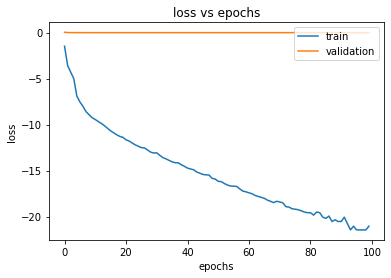

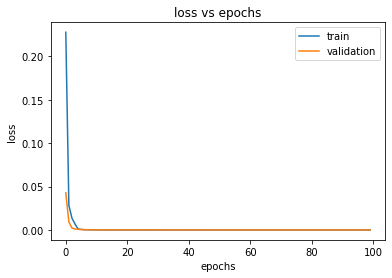

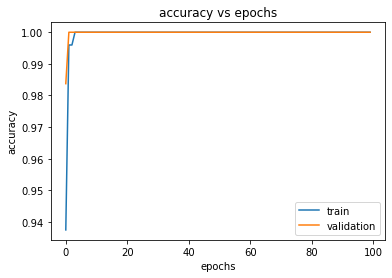

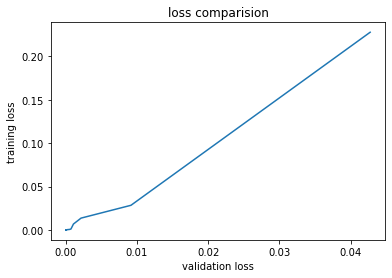

In [31]:
# plotting
logloss = tf.math.log(history.history['loss'])
plt.plot(logloss, label = ['train'])
plt.plot(history.history['val_loss'], label =['validation'])
plt.title('loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'],loc='upper right')
plt.show()

plt.plot(history.history['loss'], label = ['train'])
plt.plot(history.history['val_loss'], label =['validation'])
plt.title('loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'],loc='upper right')
plt.show()

# plotting training and validtition accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy vs epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','validation'],loc='lower right')
plt.show()

# plotting training vs validtition loss
plt.plot(history.history['val_loss'],history.history['loss'])
plt.title('loss comparision')
plt.ylabel('training loss')
plt.xlabel('validation loss')
plt.show()

In [32]:
# saving model in models trained directory
model.save('/home/neo11/Documents/ML in microfluids/models trained/inception_random')

INFO:tensorflow:Assets written to: /home/neo11/Documents/ML in microfluids/models trained/inception_random/assets


INFO:tensorflow:Assets written to: /home/neo11/Documents/ML in microfluids/models trained/inception_random/assets
